# 第四次计算物理作业
## 一、题目：
For the equations:

$$
\begin{cases}
\frac{dx}{dt}=\sigma(y-x)\\
\frac{dy}{dt}=-xz+rx-y\\
\frac{dz}{dt}=xy-bz
\end{cases}
$$

问题：
1. $\sigma=10,b=3/8,r=25$，做出z-x图像。
2. $\sigma=10,b=3/8$，改变 $r$ 值做出z-x图像。
3. 改变参数 $r$ 分别做出周期、混沌状态下的庞加莱截面。
4. 找出规则到混沌的临界r。

分析：

问题一. 初值条件为([0.5,0.5,0.5])，时间尺度为np.linspace(0,1000,50000)

问题二. 改变r值分别为50,683,684,其他条件不变。

问题三. 选取三个中分面作庞加莱截面，分别为x=a;y=b;z=c。其中任意一个面可平分空间中所有点，目的是保证交点足够多。此外选取下降零点作为庞加莱截面取点，即单方向进入x=a;y=b;z=c的点才会被记录。

选取的周期状态为r=50;混沌状态为r=683。

问题四. 历遍r取值从0-683,对每一个r值计算当前函数进行FFT，根据FFT结果判断函数（X坐标）是否存在周期即是否规律运动。

此方法的问题是r较小时x取值极小，周期性可能失效。

根据r-F结果判断规则到混沌的临界即可。

其他

1. 此代码在r=684时有发散计算会有警告。但不影响运行
2. 有二个代码块运行时间一共要5min，运行完毕会有输出提示。
## 二、作答
### （零）预处理
#### 1、准备函数
##### a.画图习惯


In [1]:
# Labrary
import numpy as np
import matplotlib.pyplot as plt
# Graph
## Library
from matplotlib.font_manager import FontProperties
## Set the font globally
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [FontProperties(fname=font_path).get_name()]
plt.rcParams['axes.unicode_minus'] = False  # Ensure the minus sign is displayed correctly

# Graph in pack
def graph(ax,x,y,x_label="x0",y_label="y0",title="Title0",legend='legend0',loc='upper left',\
          color="r",linestyle='-',linewidth=1,marker='o'):
    ## Parameter
    ### rangle
    #x_range=np.array([np.min(x)-0.1*(np.max(x)-np.min(x)),np.max(x)+0.1*(np.max(x)-np.min(x))])
    #y_range=np.array([np.min(y)-0.1*(np.max(y)-np.min(y)),np.max(y)+0.1*(np.max(y)-np.min(y))])

    ## figure
    ## plot
    ax.plot(x,y,marker=marker,color=color,linestyle=linestyle,linewidth=linewidth,label=legend)
    ## title
    ax.set_title(title,fontsize=20,weight='bold',x=0.5,y=1)
    ## legend
    ax.legend(loc=loc,prop = {'size':8})
    ## Axis
    ### label
    ax.set_xlabel(x_label,fontsize=14,labelpad=0)
    ax.set_ylabel(y_label,fontsize=14)
    ### limit
    #ax.set_xlim(x_range)
    #ax.set_ylim(y_range)
    ### tick
    #axn.set_xticks(np.linspace(0,10,4)) #x axis scale. range: 0-10，points: 4
    #axn.set_xticklabels(['you','are','so','nice'])
    ax.tick_params(axis='both',direction='in',color='black',length=5,width=1) #axis='x'or'y'or'both'
    
    return 0

##### b.服务于此题
###### 1.包装函数以Fourth order Runge-Kutta method解任意微分方程diff_right_func，注意diff_right_func的定义格式参考scipy.solve_ivp。例如：

```python
def diff_right_func(dvariable_value_array,t):#([y0,y1,y2...],x)
   x,y,z = dvariable_value_array
   diff_group_value = np.array([sigma*(y-x),-x*z+r*x-y,x*y-b*z]) #the sequence: dy_0/dx=...;dy_1/dx=...
   return diff_group_value
```

In [2]:
# Library
import numpy as np
import matplotlib.pyplot as plt

def Integral_runge_kutta4_func(dvariable_value_array, x, dx, diff_right_func):
    k1_ndarray = dx * diff_right_func(dvariable_value_array, x) #Format :ndarray
    k2_ndarray = dx * diff_right_func(dvariable_value_array + 0.5 * k1_ndarray, x + 0.5 * dx)
    k3_ndarray = dx * diff_right_func(dvariable_value_array + 0.5 * k2_ndarray, x + 0.5 * dx)
    k4_ndarray = dx * diff_right_func(dvariable_value_array + k3_ndarray, x + dx)
    return dvariable_value_array + (k1_ndarray + 2 * k2_ndarray+ 2 * k3_ndarray + k4_ndarray) / 6.
def self_integral(xdata_array,yinitial_array,Integral_func,diff_right_func):
    y=yinitial_array
    ydata=np.zeros((np.size(yinitial_array),np.size(xdata_array)))
    ydata[:,0]=y
    for i in range(np.size(xdata_array)-1):
        #intergal
        x=xdata_array[i]
        dx=xdata_array[i+1]-xdata_array[i]
        y=Integral_func(y, x, dx, diff_right_func)     
        #store
        ydata[:,i+1]=y
    return ydata

###### 2.减少变参数重复计算微分方程组的函数

In [3]:
def parameter_vary(r=25,yinitial_array=np.array([0.1,0.1,0.1]),t_array=np.linspace(0,100,1000),sigma=10,b=3/8):
    ## equation groups
    def diff_right_func(dvariable_value_array,t):#([y0,y1,y2...],x)
        x,y,z = dvariable_value_array
        diff_group_value = np.array([sigma*(y-x),-x*z+r*x-y,x*y-b*z]) #the sequence: dy_0/dx=...;dy_1/dx=...
        return diff_group_value
    sol=self_integral(t_array,yinitial_array,Integral_runge_kutta4_func,diff_right_func)
    return sol

###### 3.判断子区间是否存在下降零点

In [4]:
# 二分法判断子区间是否存在（实际不严格）下降零点
def half_down(endpoint_y):
    if endpoint_y[0]*endpoint_y[1]<=0 and endpoint_y[0]>0:
        return 1
    else:
        return 0

###### 4.三个方向上的庞加莱截面

In [5]:
# 指定数组[x;y;z]得到三个中分庞家来面上点集。
def Poincare_plane(sol_cut,median_value):
    informationx=np.array([np.array([0]),np.array([0])])
    informationy=np.array([np.array([0]),np.array([0])])
    informationz=np.array([np.array([0]),np.array([0])])

    for j in range((np.shape(sol_cut))[1]-1):
        if half_down([sol_cut[0,j],sol_cut[0,j+1]]-median_value[0]):#x=0时记录左端点y、z
            informationx=np.concatenate((informationx,np.array([np.array([sol_cut[1,j]]),np.array([sol_cut[2,j]])])),axis=1)
    for j in range((np.shape(sol_cut))[1]-1):
        if half_down([sol_cut[1,j],sol_cut[1,j+1]]-median_value[1]):#x=0时记录左端点x、z
            informationy=np.concatenate((informationy,np.array([np.array([sol_cut[0,j]]),np.array([sol_cut[2,j]])])),axis=1)
    for j in range((np.shape(sol_cut))[1]-1):
        if half_down([sol_cut[2,j],sol_cut[2,j+1]]-median_value[2]):#x=0时记录左端点x、y
            informationz=np.concatenate((informationz,np.array([np.array([sol_cut[0,j]]),np.array([sol_cut[1,j]])])),axis=1)

    return informationx[:,1:-1],informationy[:,1:-1],informationz[:,1:-1]

###### 5.FFT

In [6]:
# Library
import numpy as np
from scipy.fftpack import fft,ifft #core
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl

def FFT(t_array_cut,y_vector):
    # Date
    ## parameter
    N=np.size(t_array_cut) #采样频率，这个需要函数形式来确定。
    ## 时谐谱
    x=t_array_cut
    y=y_vector  #设置需要采样的信号，频率分量有200，400和600
    ## amplitude
    N_amplitude=np.arange(N)

    # FFT
    fft_y=fft(y)
    abs_y=np.abs(fft_y)                # 取复数的绝对值，即复数的模(双边频谱)
    angle_y=np.arange(0,N)              #取复数的角度
    ## 归一化处理（双边频谱）
    normalization_y=abs_y/N   
    ## 取半处理
    half_x = N_amplitude[range(int(N/2))]                              #取一半区间
    normalization_half_y = normalization_y[range(int(N/2))] 
    return half_x,normalization_half_y 

###### 6.减少参数变化重复FFT函数

In [7]:
def FFT_parameter_vary(t_array,r=25,yinitial_array=np.array([0.5,0.5,0.5])):
    sol25=parameter_vary(r,yinitial_array=np.array(yinitial_array),t_array=t_array)
    t_array_cut=t_array[int(1/3*(np.shape(t_array))[0]):-1]
    sol25_cut=sol25[:,int(1/3*(np.shape(sol25))[1]):-1]
    ## 采样取点，实际不需要那么多数据
    t_array_cut=t_array_cut[1:-1:5]
    sol25_cut=sol25_cut[:,1:-1:5]

    ## FFT
    half_x,normalization_half_y=FFT(t_array_cut,sol25[1,:])
    return t_array_cut,sol25_cut,half_x,normalization_half_y

###### 7.判断周期性函数

In [8]:
# Konwn half_x0,normalization_half_y0
def periodicity(half_x1,normalization_half_y1):
    standard=10*(np.sort(normalization_half_y1,axis=0))[-int(1/80*np.size(normalization_half_y1))]
    # 判断是否有周期,返回最小频率或0。
    if not(all(normalization_half_y1<standard)):
        return half_x1[np.argmax(normalization_half_y1)]
    else:
        return 0


### （一）问题一
x,y,z初值都取0.5,r取25，演化如下：
可以看出此演化后面趋于周期变化。


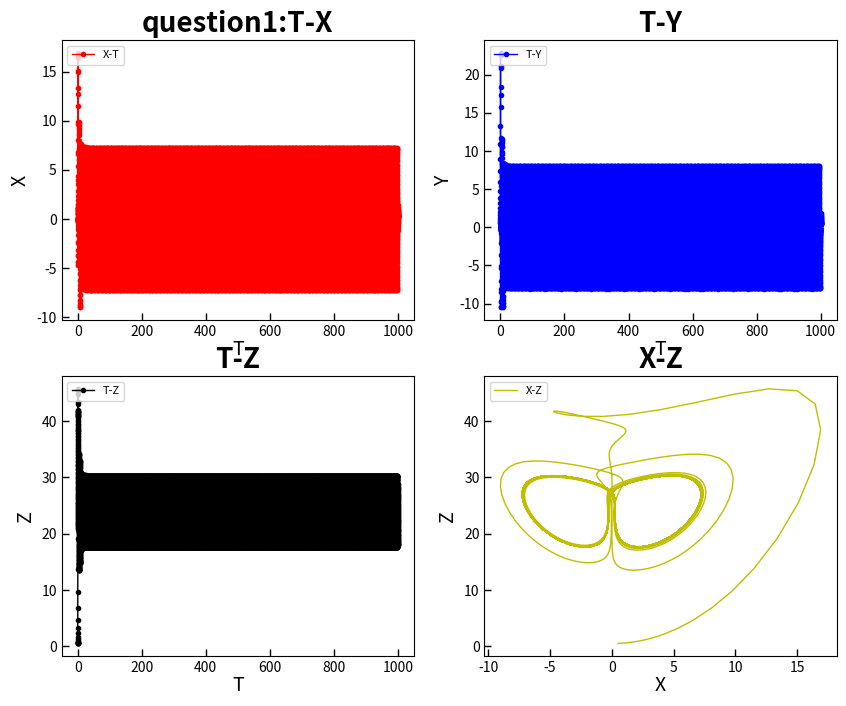

In [9]:
# Data
## parameter
t_array=np.linspace(0,1000,50000)
yinitial_array=np.array([0.5,0.5,0.5])

# Conpution
sol=parameter_vary(r=25,yinitial_array=yinitial_array,t_array=t_array)
# Graph
# fig
ax=[0,0,0,0]
fig = plt.figure(figsize=(10,8))
ax[0] = fig.add_subplot(2,2,1)
ax[1] = fig.add_subplot(2,2,2)
ax[2]= fig.add_subplot(2,2,3)
ax[3]= fig.add_subplot(2,2,4)
# plot
graph(ax[0],t_array,sol[0,:],x_label="T",y_label="X",title="question1:T-X",legend='X-T',color='r',linestyle='-',marker='.')
graph(ax[1],t_array,sol[1,:],x_label="T",y_label="Y",title="T-Y",legend='T-Y',color='b',linestyle='-',marker='.')
graph(ax[2],t_array,sol[2,:],x_label="T",y_label="Z",title="T-Z",legend='T-Z',color='k',linestyle='-',marker='.')
graph(ax[3],sol[0,:],sol[2,:],x_label="X",y_label="Z",title="X-Z",legend='X-Z',color='y',linestyle='-',marker='')
# output
plt.show()
#plt.savefig('savefig_example.eps') #eps piture

### （二）问题二
r分别改变为50，683，684为例。初值不变
(不是我要分开画，他们压根不适合画同一张图中)

/tmp/ipykernel_16622/1218607486.py:5: RuntimeWarning: overflow encountered in scalar multiply
  diff_group_value = np.array([sigma*(y-x),-x*z+r*x-y,x*y-b*z]) #the sequence: dy_0/dx=...;dy_1/dx=...
/tmp/ipykernel_16622/1218607486.py:5: RuntimeWarning: invalid value encountered in scalar subtract
  diff_group_value = np.array([sigma*(y-x),-x*z+r*x-y,x*y-b*z]) #the sequence: dy_0/dx=...;dy_1/dx=...
/tmp/ipykernel_16622/1218607486.py:5: RuntimeWarning: invalid value encountered in scalar add
  diff_group_value = np.array([sigma*(y-x),-x*z+r*x-y,x*y-b*z]) #the sequence: dy_0/dx=...;dy_1/dx=...
/tmp/ipykernel_16622/1617863990.py:10: RuntimeWarning: invalid value encountered in add
  return dvariable_value_array + (k1_ndarray + 2 * k2_ndarray+ 2 * k3_ndarray + k4_ndarray) / 6.


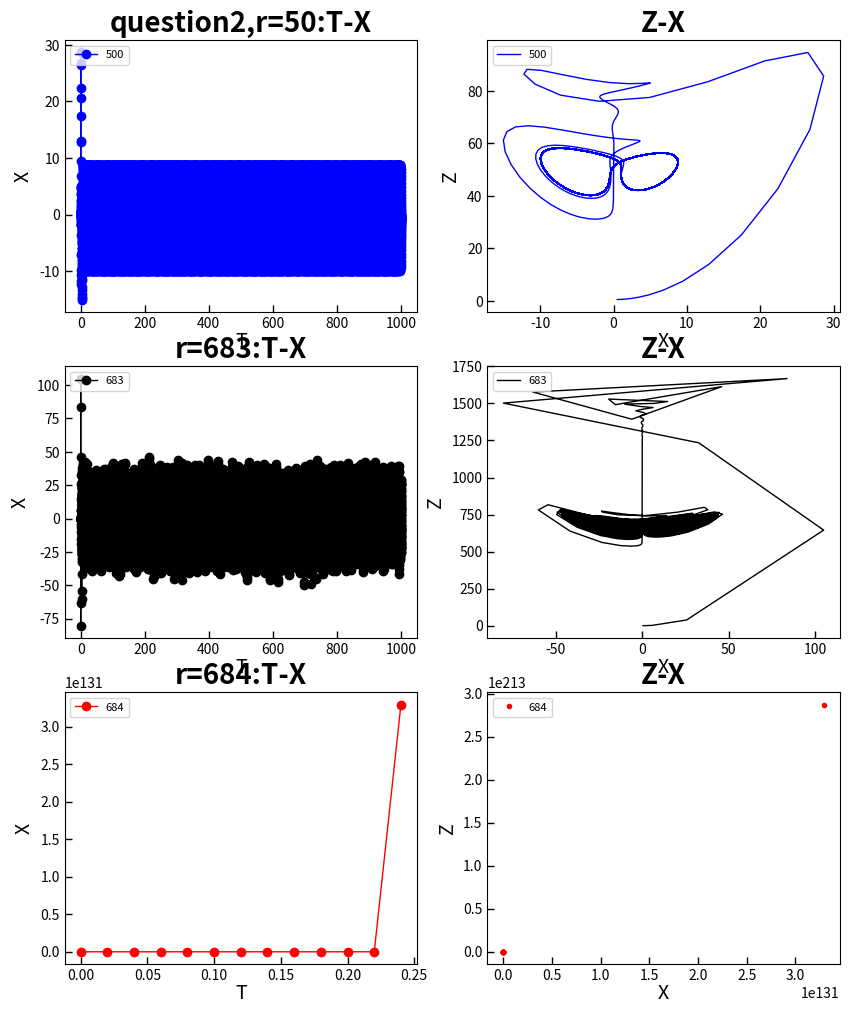

In [10]:
sol50=parameter_vary(r=50,yinitial_array=np.array(yinitial_array),t_array=t_array)
sol683=parameter_vary(r=683,yinitial_array=np.array(yinitial_array),t_array=t_array)
sol684=parameter_vary(r=684,yinitial_array=np.array(yinitial_array),t_array=t_array)

# Graph
# fig
ax=[0,0,0,0,0,0]
fig = plt.figure(figsize=(10,12))
ax[0] = fig.add_subplot(3,2,1)
ax[1] = fig.add_subplot(3,2,2)
ax[2] = fig.add_subplot(3,2,3)
ax[3] = fig.add_subplot(3,2,4)
ax[4] = fig.add_subplot(3,2,5)
ax[5] = fig.add_subplot(3,2,6)

# plot
graph(ax[4],t_array,sol684[0,:],x_label="T",y_label="X",title="r=684:T-X",legend='684',color='r',linestyle='-')
graph(ax[5],sol684[0,:],sol684[2,:],x_label="X",y_label="Z",title="Z-X",legend='684',color='r',linestyle='',marker='.')

graph(ax[2],t_array,sol683[0,:],x_label="T",y_label="X",title="r=683:T-X",legend='683',color='k',linestyle='-')
graph(ax[3],sol683[0,:],sol683[2,:],x_label="X",y_label="Z",title="Z-X",legend='683',color='k',linestyle='-',marker='')

graph(ax[0],t_array,sol50[0,:],x_label="T",y_label="X",title="question2,r=50:T-X",legend='500',color='b',linestyle='-')
graph(ax[1],sol50[0,:],sol50[2,:],x_label="X",y_label="Z",title="Z-X",legend='500',color='b',linestyle='-',marker='')
# output
plt.show()
#plt.savefig('savefig_example.eps') #eps piture

### （三）问题三
此问题其实在前二问已经得到了部分提示

1. r=25和50时显然有稳定周期
2. r=683时为混沌，或者周期极长。
3. r=684为混沌，而且极易发散

下面画庞加莱截面，注意到
1. 前面一段时间一般不稳定，我们只采用后2/3的数据作庞加莱截面。
2. 取坐标数据组的中位数，如取z=c和y=b,x=a三个面，作三个庞加莱截面。

#### 例1，如若r=50:
其截面和r=25是相当相似的，虽然我没画。

我们实际上有800个离散点，取得是中分面，所以存在轨迹漏交的可能极小；但可以看到三个截面上的下降交点范围都较小，最多是 $\pm 0.5$ 左右。其中z=22.64面上只有两个点，也即很可能在垂直此面方向上为双周期运动，即转两圈一个周期。

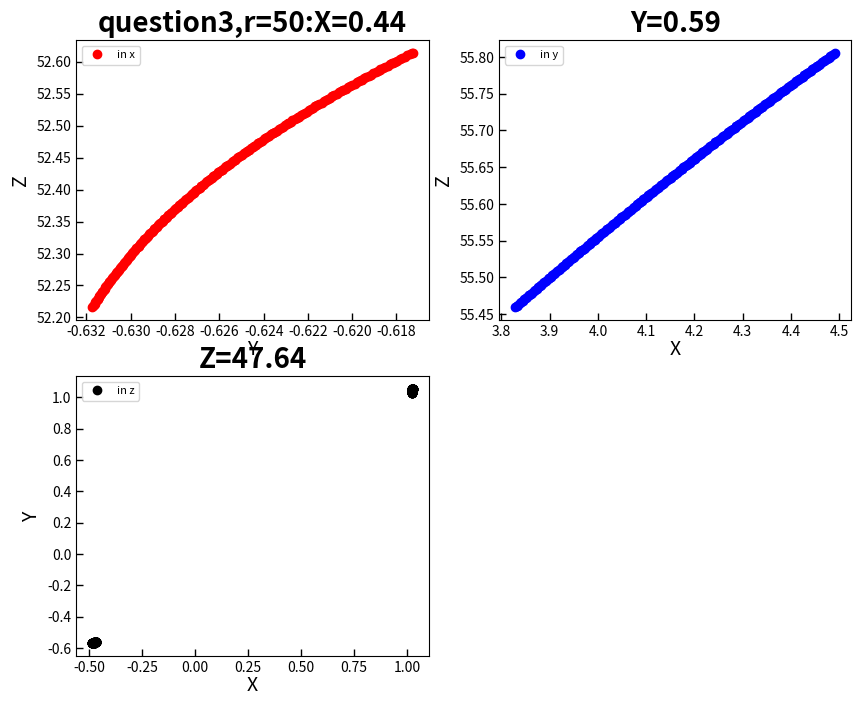

In [11]:
# Data
## 取后2/3数据，求中位数

t_array_cut=t_array[int(1/3*np.size(t_array)):-1]
sol_cut=sol50[:,int(1/3*(np.shape(sol))[1]):-1]
median_value=np.median(sol_cut,axis=1)
## 计算庞加莱面
infox,infoy,infoz=Poincare_plane(sol_cut,median_value)

# Graph
# fig
ax=[0,0,0,0,0,0]
fig = plt.figure(figsize=(10,8))
ax[0] = fig.add_subplot(2,2,1)
ax[1] = fig.add_subplot(2,2,2)
ax[2] = fig.add_subplot(2,2,3)
# plot

title_1="question3:X={}".format(median_value[0])
graph(ax[0],infox[0,:],infox[1,:],x_label="Y",y_label="Z",title="question3,r=50:X={:.2f}".format(median_value[0]),legend='in x',color='r',linestyle='')
graph(ax[1],infoy[0,:],infoy[1,:],x_label="X",y_label="Z",title="Y={:.2f}".format(median_value[1]),legend='in y',color='b',linestyle='')
graph(ax[2],infoz[0,:],infoz[1,:],x_label="X",y_label="Y",title="Z={:.2f}".format(median_value[2]),legend='in z',color='k',linestyle='')
# output
plt.show()
#plt.savefig('savefig_example.eps') #eps piture

#### 例2，r=683
有明显的混沌性质。

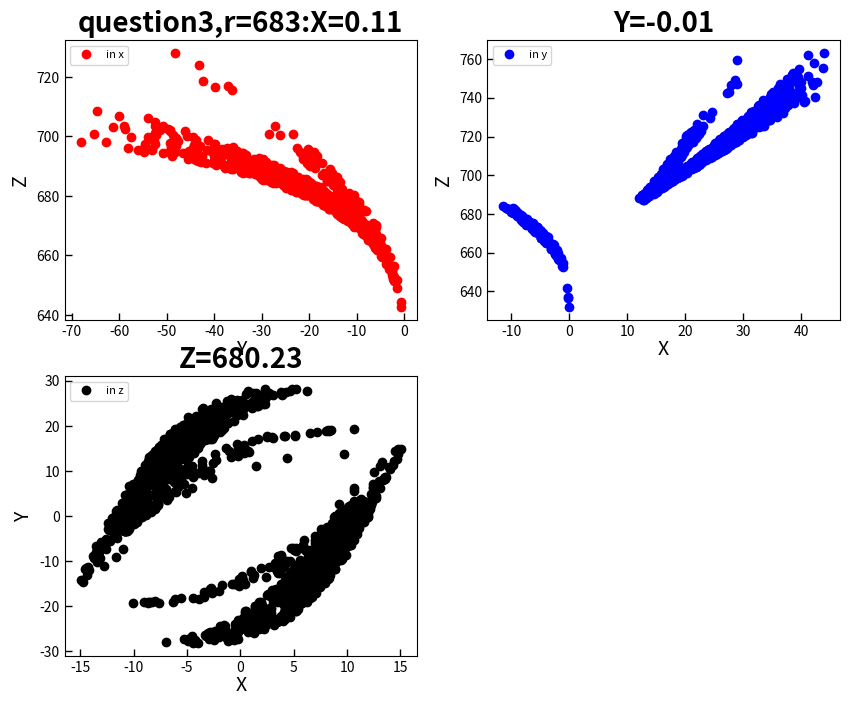

In [12]:
# Data
## 取后2/3数据，求中位数

t_array_cut=t_array[int(1/3*np.size(t_array)):-1]
sol_cut=sol683[:,int(1/3*(np.shape(sol))[1]):-1]
median_value=np.median(sol_cut,axis=1)
## 计算庞加莱面
infox,infoy,infoz=Poincare_plane(sol_cut,median_value)

# Graph
# fig
ax=[0,0,0,0,0,0]
fig = plt.figure(figsize=(10,8))
ax[0] = fig.add_subplot(2,2,1)
ax[1] = fig.add_subplot(2,2,2)
ax[2] = fig.add_subplot(2,2,3)
# plot

title_1="question3:X={}".format(median_value[0])
graph(ax[0],infox[0,:],infox[1,:],x_label="Y",y_label="Z",title="question3,r=683:X={:.2f}".format(median_value[0]),legend='in x',color='r',linestyle='')
graph(ax[1],infoy[0,:],infoy[1,:],x_label="X",y_label="Z",title="Y={:.2f}".format(median_value[1]),legend='in y',color='b',linestyle='')
graph(ax[2],infoz[0,:],infoz[1,:],x_label="X",y_label="Y",title="Z={:.2f}".format(median_value[2]),legend='in z',color='k',linestyle='')
# output
plt.show()
#plt.savefig('savefig_example.eps') #eps piture

### （四）问题四:倍周期分岔图
我刚开始嫌弃这个方法需要主关判断，后来发现严格来说没有不需要的，于是照例做了一下。

可取t_array=np.linspace(0,100,10000),照例取后2/3观察周期特征。

先以r=18和r=25为例,可以发现其周期大概是4左右，到底是多少要问上帝,观察其分布图

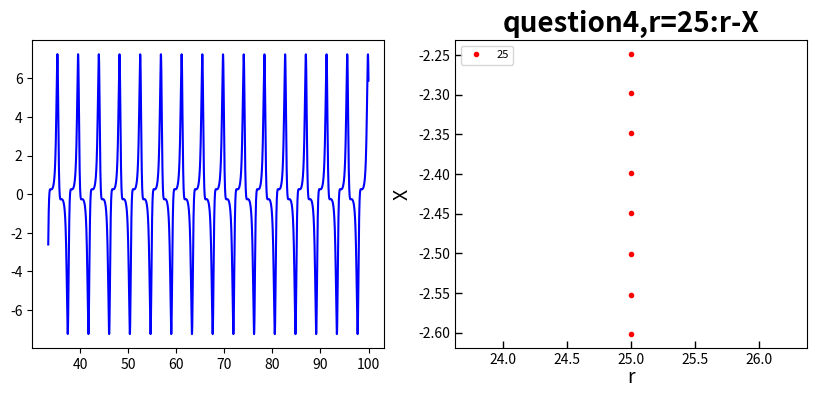

In [13]:
# Data
## 重新定义时间范围
t_array=np.linspace(0,100,10000)
start_seq=int(1/3*np.size(t_array))
t_array_cut=t_array[start_seq:-1]
# Conpution
sol=parameter_vary(r=25,yinitial_array=yinitial_array,t_array=t_array)
sol_cut=sol[0,start_seq:-1]

# period
sol_period=sol_cut[0:-1:862]
n=np.size(sol_period)
r_period=np.zeros(n)+25

# Graph
# fig
ax=[0,0,0]
fig = plt.figure(figsize=(10,4))
ax[0] = fig.add_subplot(1,2,1)
ax[1] = fig.add_subplot(1,2,2)
ax[0].plot(t_array_cut,sol_cut,color='b',linestyle='-')
graph(ax[1],r_period,sol_period,x_label="r",y_label="X",title="question4,r=25:r-X",legend='25',color='r',linestyle='',marker='.')
plt.show()


这里周期到底是多少从后面看是相当重要的，我们可以严格估计一下，即使不同sol_period=sol_cut[:,1:-1:space]的方差最小,

显然r=25，space最大选择是862，也即最大周期在862/10000*100=8.62左右。


In [14]:
# period
space_group=np.arange(1,1000,1)
para=100000
period=0

for space in space_group:
    sol_period=sol_cut[0:-1:space]
    if para>np.var(sol_period):
        period=space
        para=np.var(sol_period)
print("r=25时的一个周期:{}".format(period/10000*100))

r=25时的一个周期:8.62


同理r=18，周期在5.36左右，他们的周期（或准周期）不同。

In [15]:
# Calculation
sol=parameter_vary(r=18,yinitial_array=yinitial_array,t_array=t_array)
sol_cut=sol[0,start_seq:-1]

for space in space_group:
    sol_period=sol_cut[0:-1:space]
    if para>np.var(sol_period):
        period=space
        para=np.var(sol_period)
print("r=18时的一个周期:{}".format(period/10000*100))


r=18时的一个周期:5.36


我们只能选择一个周期做分析，选择r=18的一个周期5.36

我个人认为这看不出来什么分界,对称性也极少,根本原因在于随着r变化，系统周期随在连续变化。

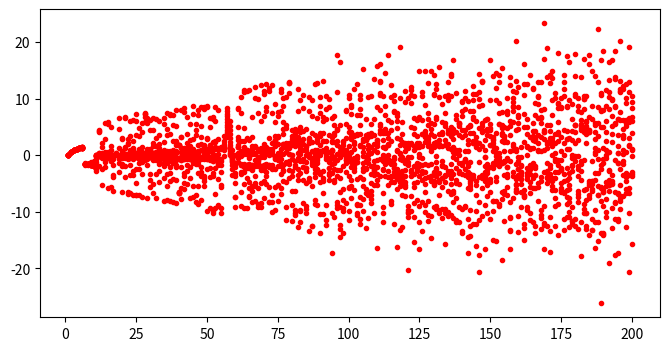

In [16]:
r_period=np.linspace(1,200,200)
num=np.size(r_period)

# plot
ax=[0,0,0,0,0,0]
fig = plt.figure(figsize=(8,4))
ax[0] = fig.add_subplot(1,1,1)

for i in range(num):
    # Conpution
    sol=parameter_vary(r=r_period[i],yinitial_array=yinitial_array,t_array=t_array)
    sol_cut=sol[:,start_seq:-1]
    # period
    sol_period=sol_cut[0,1:-1:536]
    n=np.size(sol_period)
    r_period_i=np.zeros(n)+r_period[i]
    # plot
    ax[0].plot(r_period_i,sol_period,linestyle='',marker='.',color='r')

### （五）补充FFT分析

为了简单，只讨论x方向的运动周期。
#### 分析：
我们已经看到r为684就发散了，所以我们只关心r从0到683的数据

可取t_array=np.linspace(0,250,15000),照例取后2/3观察周期特征。

我们已经包装好对于任意微分方程组任意r有parameter_vary(r=)可以计算所有演化信息，那么对于任意r如何判断x-y-z周期性呢？

课件中所用方法为t等距取 $\frac{2\pi}{W}$ 对于不同F观察 $\theta$ 行为。但这个 $\frac{2\pi}{W}$ 是一个固定值，是根据微分表达式F*np.sin(W*t)对运动周期性行为的一种猜测（或者数学上有严格依据？），是一种对数据结构的未卜先知。

可见这个方法需对数据结构提前有一定了解以便取合理的周期，又对稍长周期的运动行为不敏感，不大通用。如果坚持使用这个思路需要对所有可能的周期精细循环并验证，这一步的复杂的是 $O(n^2/2)$（偷懒只验证前几个周期会小一点），再加上r和解微分方程，整体复杂度是 $O(n^4)$，我是不配算的。
#### FFT计算周期
那到底用什么办法呢？其实前面课已经用过了，可以用FFT，挑出占比最大的频率（一般是可行频率的最小值）即可。

##### 1.采样频率：我们的采样点数相对于采样频率太高了，实际数据频率700的峰几乎没有，15000*2/3/5个点已经非常够了，也即取t_array_cut[0:-1:5]时间点数据做FFT即可。


我们先以r=25和r=500作一个对比。


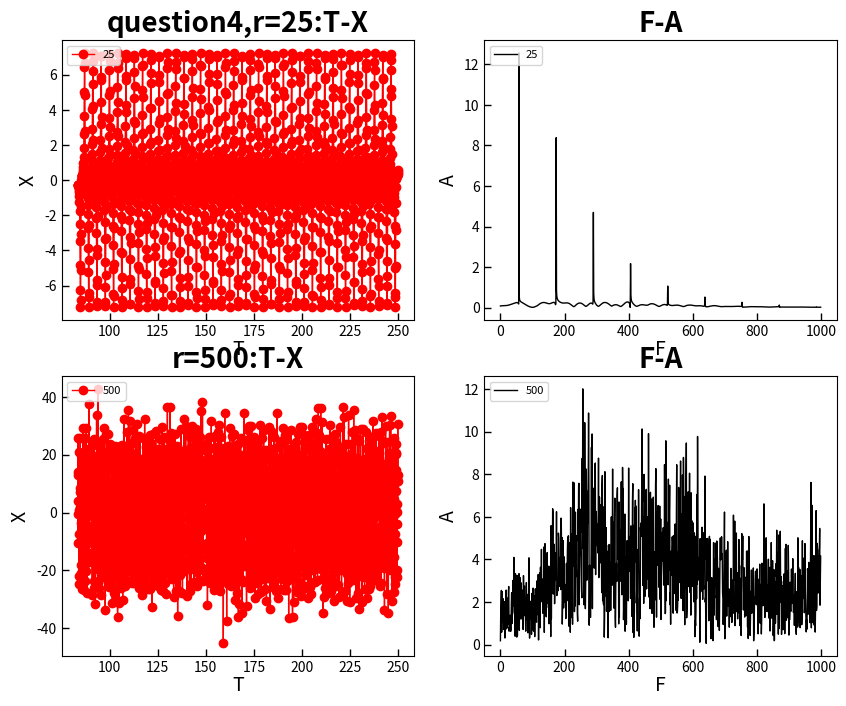

In [17]:
# Data
## 重新定义时间范围
t_array=np.linspace(0,250,15000)
## 调整r值作傅里叶变换
t_array_cut0,sol_cut0,half_x0,normalization_half_y0=FFT_parameter_vary(t_array,r=25)
t_array_cut1,sol_cut1,half_x1,normalization_half_y1=FFT_parameter_vary(t_array,r=683)

# Graph
# fig
ax=[0,0,0,0,0,0]
fig = plt.figure(figsize=((10,8)))
ax[0]=fig.add_subplot(2,2,1)
ax[1]=fig.add_subplot(2,2,2)
ax[2]=fig.add_subplot(2,2,3)
ax[3]=fig.add_subplot(2,2,4)
graph(ax[0],t_array_cut0,sol_cut0[0,:],x_label="T",y_label="X",title="question4,r=25:T-X",legend='25',color='r',linestyle='-')
graph(ax[1],half_x0,normalization_half_y0,x_label="F",y_label="A",title="F-A",legend='25',color='k',linestyle='-',marker='')
graph(ax[2],t_array_cut1,sol_cut1[0,:],x_label="T",y_label="X",title="r=500:T-X",legend='500',color='r',linestyle='-')
graph(ax[3],half_x1,normalization_half_y1,x_label="F",y_label="A",title="F-A",legend='500',color='k',linestyle='-',marker='')
plt.show()

##### 2.指定判断标准：“若在A-F图中，A的排行第1/80的大小的10倍以上依然有数据点,则认为有周期。并输出占比最大频率。否则输出频率为0，意为周期无穷大。”只是一个定性的依据。他不一定严格成立。
##### 3.设定r范围为linspace(0,684)进行迭代计算即可。

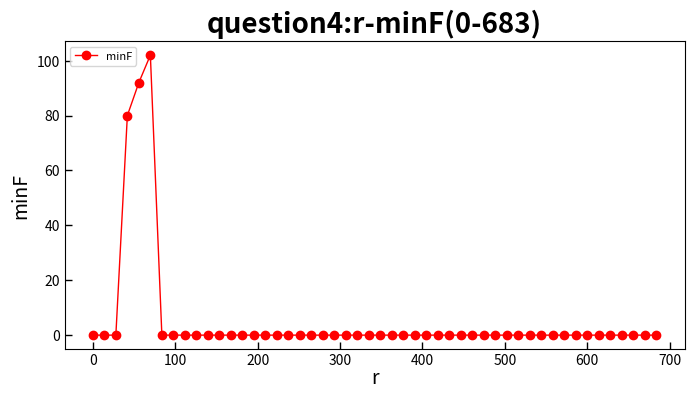

In [18]:
# Konwn half_x0,normalization_half_y0
# Data
## 重新定义时间范围
t_array=np.linspace(0,250,15000)
## 定义r循环范围
r=np.linspace(0,684,50)
n=np.size(r)
## 定义频率存储空间
F=np.zeros(n)


for i in range(n):
    # FFT
    t_array_cut0,sol_cut0,half_x0,normalization_half_y0=FFT_parameter_vary(t_array,r=r[i])
    F[i]=periodicity(half_x0,normalization_half_y0)

#plot
fig = plt.figure(figsize=((8,4)))
ax=fig.add_subplot(1,1,1)
graph(ax,r,F,x_label="r",y_label="minF",title="question4:r-minF(0-683)",legend='minF',loc='upper left',\
          color="r",linestyle='-',linewidth=1,marker='o')
plt.show()
    

##### 4.改进：显然190之后皆为混沌，我们缩小一下区间，毕竟这个代码很耗时。

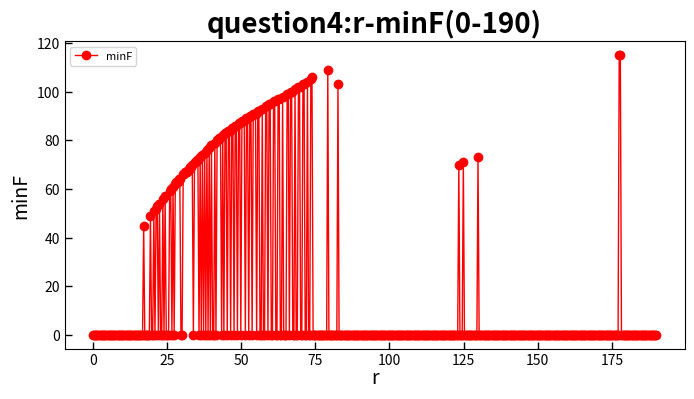

运行结束


In [19]:
# Konwn half_x0,normalization_half_y0
# Data
## 重新定义时间范围
t_array=np.linspace(0,250,15000)
## 定义r循环范围
r=np.linspace(0,190,500)
n=np.size(r)
## 定义频率存储空间
F=np.zeros(n)


for i in range(n):
    # FFT
    t_array_cut0,sol_cut0,half_x0,normalization_half_y0=FFT_parameter_vary(t_array,r=r[i])
    F[i]=periodicity(half_x0,normalization_half_y0)

#plot
fig = plt.figure(figsize=((8,4)))
ax=fig.add_subplot(1,1,1)
graph(ax,r,F,x_label="r",y_label="minF",title="question4:r-minF(0-190)",legend='minF',loc='upper left',\
          color="r",linestyle='-',linewidth=1,marker='o')
plt.show()
print("运行结束")

显然规则区域聚集在75到80左右，我们并不能很严格的找到这个所谓规则和混沌的界限，这是因为我们制定的规则“若在A-F图中，A的排行第1/80的大小的10倍以上依然有数据点,则认为有周期。并输出占比最大频率。否则输出频率为0，意为周期无穷大。”只是一个定性的依据。他不一定严格成立。

但r在11之下的时候，x值几乎不怎么变，所以频率很低，不能断定就是混沌状态了。即它x方向压根不动，讨论周期没啥用。

##### 5.以边界旁边的点作对比
对比r=[70,80]的图像对比，会发现r=80周期性下降很多。r=80的FFT图像噪音极多

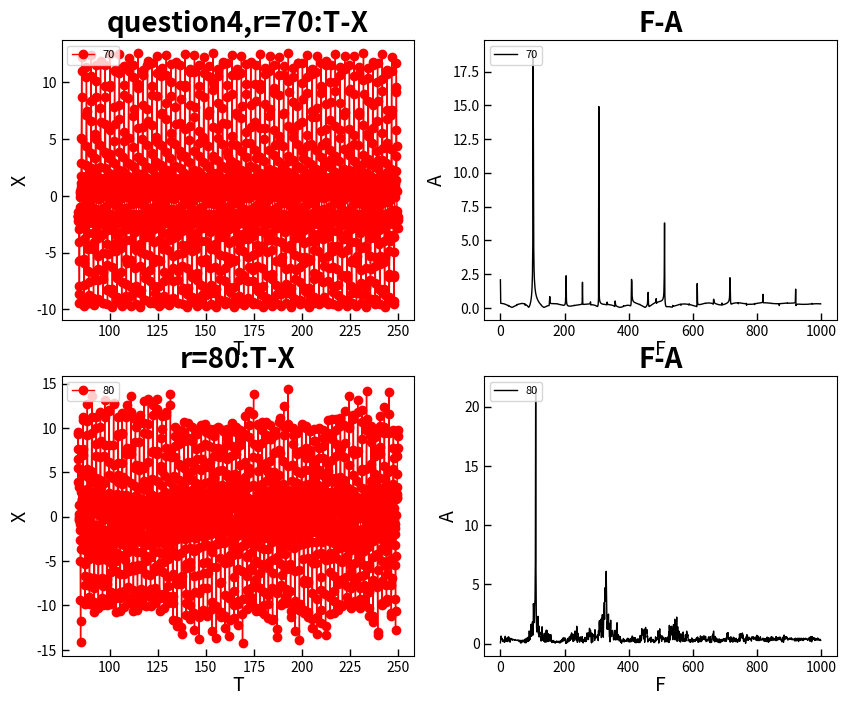

In [20]:
# Data
## 重新定义时间范围
t_array=np.linspace(0,250,15000)
## 调整r值作傅里叶变
t_array_cut0,sol_cut0,half_x0,normalization_half_y0=FFT_parameter_vary(t_array,r=70)
t_array_cut1,sol_cut1,half_x1,normalization_half_y1=FFT_parameter_vary(t_array,r=80)

# Graph
# fig
ax=[0,0,0,0,0,0]
fig = plt.figure(figsize=((10,8)))
ax[0]=fig.add_subplot(2,2,1)
ax[1]=fig.add_subplot(2,2,2)
ax[2]=fig.add_subplot(2,2,3)
ax[3]=fig.add_subplot(2,2,4)
graph(ax[0],t_array_cut0,sol_cut0[0,:],x_label="T",y_label="X",title="question4,r=70:T-X",legend='70',color='r',linestyle='-')
graph(ax[1],half_x0,normalization_half_y0,x_label="F",y_label="A",title="F-A",legend='70',color='k',linestyle='-',marker='')
graph(ax[2],t_array_cut1,sol_cut1[0,:],x_label="T",y_label="X",title="r=80:T-X",legend='80',color='r',linestyle='-')
graph(ax[3],half_x1,normalization_half_y1,x_label="F",y_label="A",title="F-A",legend='80',color='k',linestyle='-',marker='')
plt.show()

## 五、结果
我们的初值[0.5,0.5,0.5]计算的结果规则到混沌的临界为r在70到80之间。

我们无法完全确定临界r的精确值。这是因为随着r的接近临界，数据周期性的丢失是一个连续的变化，随着r变化的周期也是个连续变化的值，我们给的判定标准是一刀切(算是比较严格的一刀切了)，这显然不太合适，但也没办法。

换言之，有限的离散数据集无法区分无穷大周期和不成周期。运动的频率分量的周期总有最小公倍数，我只能对分量个数限制。

而且由于初始条件的敏感性，这东西算出来没有一点用。

书上说进入混沌的界限是r=24.74。这大概是个针对所有初值的必要条件，或者说是r>24.74后，演化轨迹对初值条件极为敏感。

我如果有一台超级计算机，一微秒钟可以把这个代码跑完的那种，我一定把所有初值跑一遍，得到规律进入混沌的最低r

但是我现在饿了，要吃饭。